In [1]:
#!/usr/bin/env python3

import os
import sys
import geopandas as gpd
sys.path.append('/foss_fim/src')
from shapely.geometry import Point, LineString
import rasterio
import numpy as np
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from os.path import join
from multiprocessing import Pool
from utils.shared_functions import getDriver
from rasterio import features
from reachID_grid_to_vector_points import convert_grid_cells_to_points
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Matplotlib is building the font cache; this may take a moment.


In [3]:
%matplotlib widget

def compare_thalweg(args):

    huc_dir                             = args[0]
    stream_type                         = args[1]
    point_density                       = args[2]
    huc                                 = args[3]
    dem_meters_filename                 = args[4]
    dem_lateral_thalweg_adj_filename    = args[5]
    dem_thalwegCond_filename            = args[6]
    profile_plots_filename              = args[7]
    profile_gpkg_filename               = args[8]
    profile_table_filename              = args[9]
    flows_grid_boolean_filename         = args[10]
    lateral_elevation_threshold         = float(args[11])

    print(huc)

    if stream_type == 'derived':

        dem_derived_reaches_filename = os.path.join(huc_dir,'demDerived_reaches_split.gpkg')
        streams = gpd.read_file(dem_derived_reaches_filename)
        nhd_headwater_filename = os.path.join(huc_dir,'nhd_headwater_points_subset.gpkg')
        wbd_filename = os.path.join(huc_dir,'wbd.gpkg')
        wbd = gpd.read_file(wbd_filename)
        headwaters_layer = gpd.read_file(nhd_headwater_filename,mask=wbd)
#        headwater_list = headwaters_layer.loc[(headwaters_layer.mainstem == True) | (headwaters_layer.site_id == "20000500022988")]
        headwater_list = headwaters_layer.loc[headwaters_layer.mainstem == True]
        stream_id = 'HydroID'

    elif stream_type == 'burnline':

        nhd_reaches_filename = os.path.join(huc_dir,'NHDPlusBurnLineEvent_subset.gpkg')
        nhd_reaches = gpd.read_file(nhd_reaches_filename)
        streams = nhd_reaches.copy()
        headwaters_layer = None

        # Get lists of all complete reaches using headwater attributes
        headwater_list = streams.loc[streams.nws_lid!=''].nws_lid
        stream_id = 'NHDPlusID'

    headwater_col = 'is_headwater'
    streams[headwater_col] = False
    headwater_list = headwater_list.reset_index(drop=True)

    if stream_type == 'derived':
        streams['nws_lid'] = ''

        if streams.NextDownID.dtype != 'int': streams.NextDownID = streams.NextDownID.astype(int)

        min_dist = np.empty(len(headwater_list))
        streams['min_dist'] = 1000

        for i, point in headwater_list.iterrows():
            streams['min_dist'] = [point.geometry.distance(line) for line in streams.geometry]
            streams.loc[streams.min_dist==np.min(streams.min_dist),'nws_lid'] = point.site_id

        headwater_list = headwater_list.site_id

    streams.set_index(stream_id,inplace=True,drop=False)

    # Collect headwater streams
    single_stream_paths = []
    dem_meters = rasterio.open(dem_meters_filename,'r')
    dem_thalwegCond = rasterio.open(dem_thalwegCond_filename,'r')
    index_option = 'reachID'
    for index, headwater_site in enumerate(headwater_list):
        stream_path = get_downstream_segments(streams.copy(),'nws_lid', headwater_site,'downstream',stream_id,stream_type)
        stream_path = stream_path.reset_index(drop=True)
        stream_path = stream_path.sort_values(by=['downstream_count'])
        stream_path = stream_path.loc[stream_path.downstream==True]
        if stream_type == 'burnline':
            geom_value = []
            for index, segment in stream_path.iterrows():
                lineString = LineString(segment.geometry.coords[::-1])
                geom_value = geom_value + [(lineString, segment.downstream_count)]
            nhd_reaches_raster = features.rasterize(shapes=geom_value , out_shape=[dem_thalwegCond.height, dem_thalwegCond.width],fill=dem_thalwegCond.nodata,transform=dem_thalwegCond.transform, all_touched=True, dtype=np.float32)
            flow_bool = rasterio.open(flows_grid_boolean_filename)
            flow_bool_data = flow_bool.read(1)
            nhd_reaches_raster = np.where(flow_bool_data == int(0), -9999.0, (nhd_reaches_raster).astype(rasterio.float32))
            out_dem_filename = os.path.join(huc_dir,'NHDPlusBurnLineEvent_raster.tif')
            with rasterio.open(out_dem_filename, "w", **dem_thalwegCond.profile, BIGTIFF='YES') as dest:
                dest.write(nhd_reaches_raster, indexes = 1)
            stream_path = convert_grid_cells_to_points(out_dem_filename,index_option)
        stream_path["headwater_path"] = headwater_site
        single_stream_paths = single_stream_paths + [stream_path]
        print(f"length of {headwater_site} path: {len(stream_path)}")

    # Collect elevation values from multiple grids along each individual reach point
    dem_lateral_thalweg_adj = rasterio.open(dem_lateral_thalweg_adj_filename,'r')
    thalweg_points = gpd.GeoDataFrame()
    for path in single_stream_paths:
        split_points = []
        stream_ids = []
        dem_m_elev = []
        dem_burned_filled_elev = []
        dem_lat_thal_adj_elev = []
        dem_thal_adj_elev = []
        headwater_path = []
        index_count = []
        for index, segment in path.iterrows():
            if stream_type == 'derived':
                linestring = segment.geometry
                if point_density == 'midpoints':
                    midpoint = linestring.interpolate(0.5,normalized=True)
                    stream_ids = stream_ids + [segment[stream_id]]
                    split_points = split_points + [midpoint]
                    index_count = index_count + [segment.downstream_count]
                    dem_m_elev = dem_m_elev + [np.array(list(dem_meters.sample((Point(midpoint).coords), indexes=1))).item()]
                    dem_lat_thal_adj_elev = dem_lat_thal_adj_elev + [np.array(list(dem_lateral_thalweg_adj.sample((Point(midpoint).coords), indexes=1))).item()]
                    dem_thal_adj_elev = dem_thal_adj_elev + [np.array(list(dem_thalwegCond.sample((Point(midpoint).coords), indexes=1))).item()]
                    headwater_path = headwater_path + [segment.headwater_path]
                elif point_density == 'all_points':
                    count=0
                    for point in zip(*linestring.coords.xy):
                        stream_ids = stream_ids + [segment[stream_id]]
                        split_points = split_points + [Point(point)]
                        count = count + 1
                        index_count = index_count + [segment.downstream_count*1000 + count]
                        dem_m_elev = dem_m_elev + [np.array(list(dem_meters.sample((Point(point).coords), indexes=1))).item()]
                        dem_lat_thal_adj_elev = dem_lat_thal_adj_elev + [np.array(list(dem_lateral_thalweg_adj.sample((Point(point).coords), indexes=1))).item()]
                        dem_thal_adj_elev = dem_thal_adj_elev + [np.array(list(dem_thalwegCond.sample((Point(point).coords), indexes=1))).item()]
                        headwater_path = headwater_path + [segment.headwater_path]
            elif stream_type == 'burnline':
                stream_ids = stream_ids + [segment['id']]
                split_points = split_points + [Point(segment.geometry)]
                index_count = index_count + [segment['id']]
                dem_m_elev = dem_m_elev + [np.array(list(dem_meters.sample((Point(segment.geometry).coords), indexes=1))).item()]
                dem_lat_thal_adj_elev = dem_lat_thal_adj_elev + [np.array(list(dem_lateral_thalweg_adj.sample((Point(segment.geometry).coords), indexes=1))).item()]
                dem_thal_adj_elev = dem_thal_adj_elev + [np.array(list(dem_thalwegCond.sample((Point(segment.geometry).coords), indexes=1))).item()]
                headwater_path = headwater_path + [segment.headwater_path]
        # gpd.GeoDataFrame({**data, "source": "dem_m"})
        dem_m_pts = gpd.GeoDataFrame({'stream_id': stream_ids, 'source': 'dem_m', 'elevation_m': dem_m_elev, 'headwater_path': headwater_path, 'index_count': index_count, 'geometry': split_points}, crs=path.crs, geometry='geometry')
        dem_lat_thal_adj_pts = gpd.GeoDataFrame({'stream_id': stream_ids, 'source': 'dem_lat_thal_adj', 'elevation_m': dem_lat_thal_adj_elev, 'headwater_path': headwater_path, 'index_count': index_count, 'geometry': split_points}, crs=path.crs, geometry='geometry')
        dem_thal_adj_pts = gpd.GeoDataFrame({'stream_id': stream_ids, 'source': 'thal_adj_dem', 'elevation_m': dem_thal_adj_elev, 'headwater_path': headwater_path, 'index_count': index_count, 'geometry': split_points}, crs=path.crs, geometry='geometry')
        for raster in [dem_m_pts,dem_lat_thal_adj_pts,dem_thal_adj_pts]:
            raster = raster.sort_values(by=['index_count'])
            raster.set_index('index_count',inplace=True,drop=True)
            raster = raster.reset_index(drop=True)
            raster.index.names = ['index_count']
            raster = raster.reset_index(drop=False)
            thalweg_points = thalweg_points.append(raster,ignore_index = True)
            del raster
        del dem_lat_thal_adj_pts,dem_thal_adj_pts,dem_m_pts

    del dem_lateral_thalweg_adj,dem_thalwegCond,

    try:
        # Remove nodata_pts and convert elevation to ft
        thalweg_points = thalweg_points.loc[thalweg_points.elevation_m > 0.0]
        thalweg_points.elevation_m =  np.round(thalweg_points.elevation_m,3)
        thalweg_points['elevation_ft'] =  np.round(thalweg_points.elevation_m*3.28084,3)
        thalweg_points['huc8'] = huc

        # Plot thalweg profile
        #plot_profile(thalweg_points, profile_plots_filename)

        # Filter final thalweg ajdusted layer
        thal_adj_points = thalweg_points.loc[thalweg_points.source=='thal_adj_dem'].copy()
        # thal_adj_points.to_file(profile_gpkg_filename,driver=getDriver(profile_gpkg_filename))

        # Identify significant rises/drops in elevation
        thal_adj_points['elev_change'] = thal_adj_points.groupby(['headwater_path', 'source'])['elevation_m'].apply(lambda x: x - x.shift())
        elev_changes = thal_adj_points.loc[(thal_adj_points.elev_change<=-lateral_elevation_threshold) | (thal_adj_points.elev_change>0.0)]

        if not elev_changes.empty:
            # elev_changes.to_csv(profile_table_filename,index=False)
            #elev_changes.to_file(profile_gpkg_filename,index=False,driver=getDriver(profile_gpkg_filename))
            pass


        # Zoom in to plot only areas with steep elevation changes
        # select_streams = elev_changes.stream_id.to_list()
        # downstream_segments = [index + 1 for index in select_streams]
        # upstream_segments = [index - 1 for index in select_streams]
        # select_streams = list(set(upstream_segments + downstream_segments + select_streams))
        # thal_adj_points_select = thal_adj_points.loc[thal_adj_points.stream_id.isin(select_streams)]
        # plot_profile(thal_adj_points_select, profile_plots_filename_zoom)

    except:
        print(f"huc {huc} has {len(thalweg_points)} thalweg points")

    return thalweg_points

def get_downstream_segments(streams, headwater_col,headwater_id,flag_column,stream_id,stream_type):

    streams[flag_column] = False
    streams['downstream_count'] = -9
    streams.loc[streams[headwater_col]==headwater_id,flag_column] = True
    streams.loc[streams[headwater_col]==headwater_id,'downstream_count'] = 0
    count = 0

    Q = deque(streams.loc[streams[headwater_col]==headwater_id,stream_id].tolist())
    visited = set()

    while Q:
        q = Q.popleft()

        if q in visited:
            continue

        visited.add(q)

        count = count + 1
        if stream_type == 'burnline':

            toNode,DnLevelPat = streams.loc[q,['ToNode','DnLevelPat']]
            downstream_ids = streams.loc[streams['FromNode'] == toNode,:].index.tolist()

            # If multiple downstream_ids are returned select the ids that are along the main flow path (i.e. exclude segments that are diversions)
            if len(set(downstream_ids)) > 1: # special case: remove duplicate NHDPlusIDs

                relevant_ids = [segment for segment in downstream_ids if DnLevelPat == streams.loc[segment,'LevelPathI']]

            else:

                relevant_ids = downstream_ids

        elif stream_type == 'derived':

            toNode = streams.loc[q,['NextDownID']].item()
            relevant_ids = streams.loc[streams[stream_id] == toNode,:].index.tolist()

        streams.loc[relevant_ids,flag_column] = True
        streams.loc[relevant_ids,'downstream_count'] = count

        for i in relevant_ids:

            if i not in visited:
                Q.append(i)

    streams = streams.loc[streams[flag_column],:]

    return streams


def plot_profile(elevation_table,profile_plots_filename=None):
    num_plots = len(elevation_table.headwater_path.unique())
    unique_rasters = elevation_table.source.unique()
    # if num_plots > 3:
    #     columns = int(np.ceil(num_plots / 3))
    # else:
    #     columns = 1
    columns = 1
    # palette = dict(zip(unique_rasters, sns.color_palette(n_colors=len(unique_rasters))))
    # palette.update({'dem_m':'gray'})
    sns.set(style="ticks")
    if len(unique_rasters) > 1:
        g = sns.FacetGrid(elevation_table, col="headwater_path", hue="source", hue_order=['dem_m', 'dem_lat_thal_adj', 'thal_adj_dem'], sharex=False, sharey=False,col_wrap=columns,
                          height=4, aspect=1.75)
    else:
        g = sns.FacetGrid(elevation_table, col="headwater_path", hue="source", sharex=False, sharey=False,col_wrap=columns)
    g.map(sns.lineplot, "index_count", "elevation_ft", palette="tab20c")
    g.set_axis_labels(x_var="Longitudinal Profile (index)", y_var="Elevation (ft)")
    # Iterate thorugh each axis to get individual y-axis bounds
    for ax in g.axes.flat:
        mins = []
        maxes = []
        for line in ax.lines:
            mins = mins + [min(line.get_ydata())]
            maxes = maxes + [max(line.get_ydata())]
        min_y = min(mins) - (max(maxes) - min(mins))/10
        max_y = max(maxes) + (max(maxes) - min(mins))/10
        ax.set_ylim(min_y,max_y)
    # if len(unique_rasters) > 1:
    #     ax.lines[0].set_linestyle("--")
    #     ax.lines[0].set_color('gray')
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
    # Adjust the arrangement of the plots
    # g.fig.tight_layout(w_pad=5) #w_pad=2
    g.add_legend()
    # plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    plt.subplots_adjust(bottom=0.25)
    #plt.savefig(profile_plots_filename)
    #plt.close()
    plt.show()


In [4]:
huc_dir                             = r"/data/outputs/single_pixel_inundation_14010005/14010005/"
stream_type                         = "derived"
point_density                       = "all_points"
huc                                 = "14010005"
dem_meters_filename                 = os.path.join(huc_dir,'dem_meters.tif')
dem_lateral_thalweg_adj_filename    = os.path.join(huc_dir,'dem_lateral_thalweg_adj.tif')
dem_thalwegCond_filename            = os.path.join(huc_dir,'dem_thalwegCond.tif')
profile_plots_filename              = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/plots/",f"profile_drop_plots_{huc}_{point_density}_{stream_type}.png")
profile_gpkg_filename               = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/spatial/",f"thalweg_elevation_changes_{huc}_{point_density}_{stream_type}.gpkg")
profile_table_filename              = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/spatial/",f"thalweg_elevation_changes_{huc}_{point_density}_{stream_type}.csv")
flows_grid_boolean_filename         = os.path.join(huc_dir,'flows_grid_boolean.tif')
lateral_elevation_threshold         = 3.0

thalweg_points = compare_thalweg([huc_dir,
                                  stream_type,
                                  point_density,
                                  huc,
                                  dem_meters_filename,
                                  dem_lateral_thalweg_adj_filename,
                                  dem_thalwegCond_filename,
                                  profile_plots_filename,
                                  profile_gpkg_filename,
                                  profile_table_filename,
                                  flows_grid_boolean_filename,
                                  lateral_elevation_threshold])
thalweg_points

14010005
length of WETC2 path: 228
length of PCCC2 path: 109
length of RRGC2 path: 197
length of 41000300019648 path: 231


,index_count,stream_id,source,elevation_m,headwater_path,geometry,elevation_ft,huc8
0,0,26250646,dem_m,2153.89,WETC2,POINT (-986610.000 1872040.000),7066.568,14010005
1,1,26250646,dem_m,2153.75,WETC2,POINT (-986620.000 1872050.000),7066.109,14010005
2,2,26250646,dem_m,2153.41,WETC2,POINT (-986630.000 1872060.000),7064.994,14010005
3,3,26250646,dem_m,2153.98,WETC2,POINT (-986640.000 1872070.000),7066.864,14010005
4,4,26250646,dem_m,2152.92,WETC2,POINT (-986630.000 1872080.000),7063.386,14010005
...,...,...,...,...,...,...,...,...
334366,32599,26320001,thal_adj_dem,1306.53,41000300019648,POINT (-1122120.000 1858710.000),4286.516,14010005
334367,32600,26320001,thal_adj_dem,1306.53,41000300019648,POINT (-1122130.000 1858700.000),4286.516,14010005
334368,32601,26320001,thal_adj_dem,1306.52,41000300019648,POINT (-1122130.000 1858690.000),4286.483,14010005
334369,32602,26320001,thal_adj_dem,1306.52,41000300019648,POINT (-1122140.000 1858680.000),4286.483,14010005


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
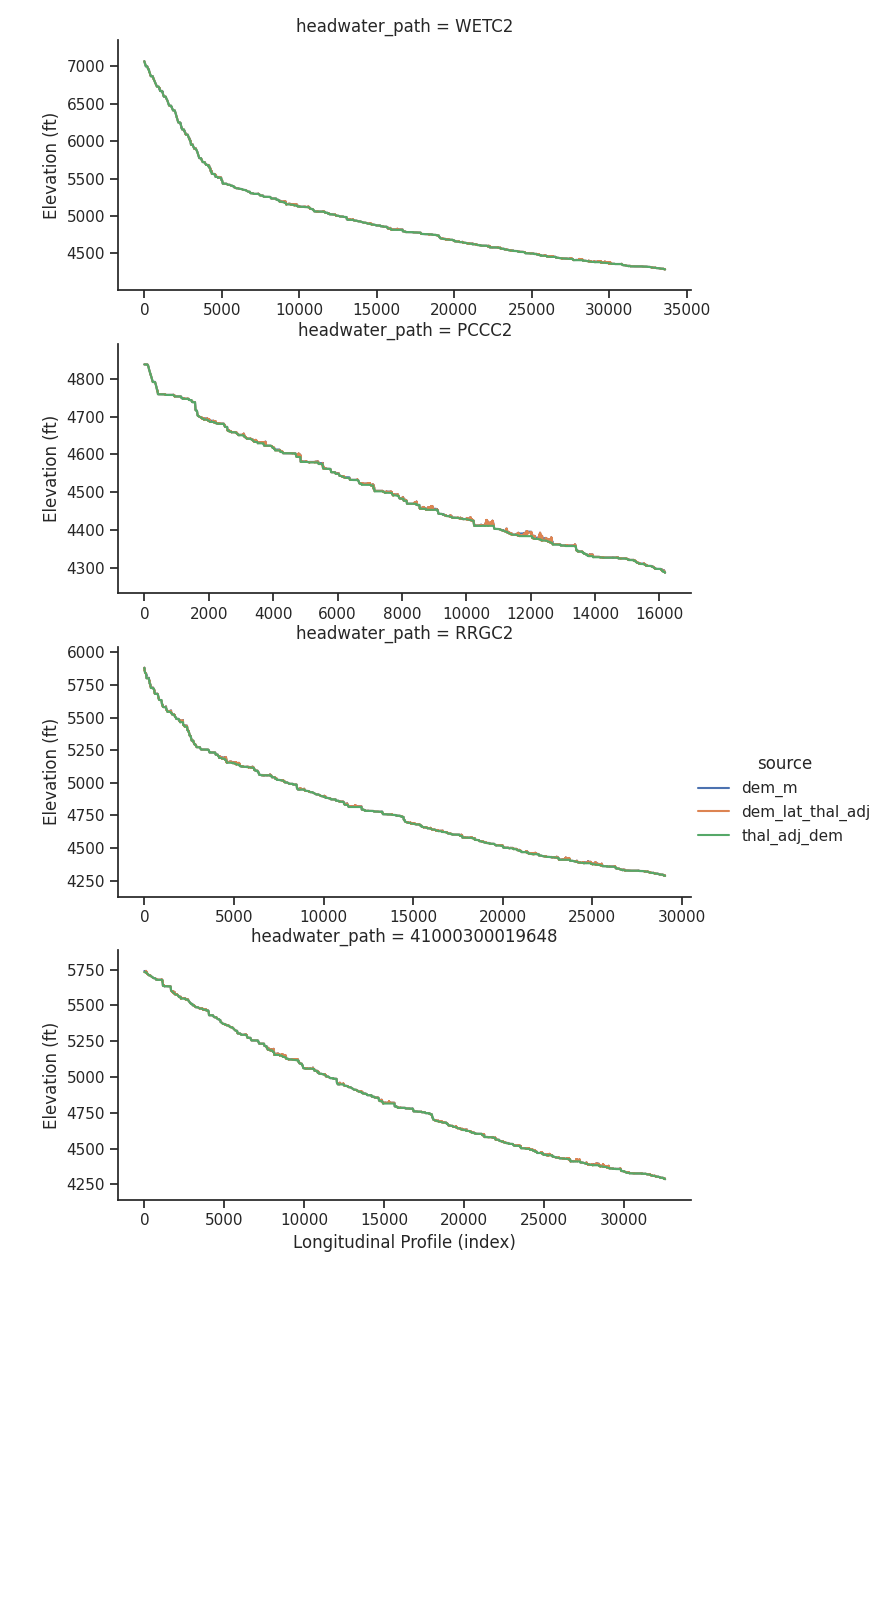

In [8]:
plot_profile(thalweg_points)

In [ ]:
# Single pixel inundation for entire HUC
# 08030100 and 05140104 
# Hamed 12040101 | hmmt2 lgrt2 (12090301)
huc_dir                             = r"/data/outputs/single_pixel_inundation_08030100/08030100/"
stream_type                         = "derived"
point_density                       = "all_points"
huc                                 = "08030100"
dem_meters_filename                 = os.path.join(huc_dir,'dem_meters.tif')
dem_lateral_thalweg_adj_filename    = os.path.join(huc_dir,'dem_lateral_thalweg_adj.tif')
dem_thalwegCond_filename            = os.path.join(huc_dir,'dem_thalwegCond.tif')
profile_plots_filename              = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/plots/",f"profile_drop_plots_{huc}_{point_density}_{stream_type}.png")
profile_gpkg_filename               = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/spatial/",f"thalweg_elevation_changes_{huc}_{point_density}_{stream_type}.gpkg")
profile_table_filename              = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/spatial/",f"thalweg_elevation_changes_{huc}_{point_density}_{stream_type}.csv")
flows_grid_boolean_filename         = os.path.join(huc_dir,'flows_grid_boolean.tif')
lateral_elevation_threshold         = 3.0

thalweg_points = compare_thalweg([huc_dir,
                                  stream_type,
                                  point_density,
                                  huc,
                                  dem_meters_filename,
                                  dem_lateral_thalweg_adj_filename,
                                  dem_thalwegCond_filename,
                                  profile_plots_filename,
                                  profile_gpkg_filename,
                                  profile_table_filename,
                                  flows_grid_boolean_filename,
                                  lateral_elevation_threshold])

Error: Kernel is dead

In [ ]:
nhd_headwater_filename = os.path.join(huc_dir,'nhd_headwater_points_subset.gpkg')
wbd_filename = os.path.join(huc_dir,'wbd.gpkg')
wbd = gpd.read_file(wbd_filename)
headwaters_layer = gpd.read_file(nhd_headwater_filename,mask=wbd)
headwater_list = headwaters_layer.loc[(headwaters_layer.mainstem == True) | (headwaters_layer.site_id == "20000500022988")]
headwater_list

In [ ]:
huc_dir                             = r"/data/outputs/single_pixel_inundation_08030100/05140104/"
stream_type                         = "derived"
point_density                       = "all_points"
huc                                 = "05140104"
dem_meters_filename                 = os.path.join(huc_dir,'dem_meters.tif')
dem_lateral_thalweg_adj_filename    = os.path.join(huc_dir,'dem_lateral_thalweg_adj.tif')
dem_thalwegCond_filename            = os.path.join(huc_dir,'dem_thalwegCond.tif')
profile_plots_filename              = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/plots/",f"profile_drop_plots_{huc}_{point_density}_{stream_type}.png")
profile_gpkg_filename               = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/spatial/",f"thalweg_elevation_changes_{huc}_{point_density}_{stream_type}.gpkg")
profile_table_filename              = os.path.join(r"/data/tools/thalweg_profile_comparison/fim_3_0_22_6/spatial/",f"thalweg_elevation_changes_{huc}_{point_density}_{stream_type}.csv")
flows_grid_boolean_filename         = os.path.join(huc_dir,'flows_grid_boolean.tif')
lateral_elevation_threshold         = 3.0

thalweg_points = compare_thalweg([huc_dir,
                                  stream_type,
                                  point_density,
                                  huc,
                                  dem_meters_filename,
                                  dem_lateral_thalweg_adj_filename,
                                  dem_thalwegCond_filename,
                                  profile_plots_filename,
                                  profile_gpkg_filename,
                                  profile_table_filename,
                                  flows_grid_boolean_filename,
                                  lateral_elevation_threshold])

In [23]:
import gdal, numpy as np, geopandas as gpd, pandas as pd
dem_thalweg_difference = gdal.Open(r"/data/outputs/single_pixel_inundation_08030100/05140104/dem_thalweg_difference.tif")
dem_thalweg_difference_arr = dem_thalweg_difference.GetRasterBand(1).ReadAsArray()

In [4]:
dem_thalweg_difference_arr[dem_thalweg_difference_arr>100000]=np.nan
#dem_thalweg_difference_arr[dem_thalweg_difference_arr==0]=np.nan
#len(dem_thalweg_difference_arr[dem_thalweg_difference_arr>0])
dem_thalweg_difference_arr

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [5]:
mean = np.nanmean(dem_thalweg_difference_arr)
stdev = np.nanstd(dem_thalweg_difference_arr)
median = np.nanmedian(dem_thalweg_difference_arr)
print(f"Mean: {mean}")
print(f"St Dev: {stdev}")
print(f"Median: {median}")

#len(dem_thalweg_difference_arr[dem_thalweg_difference_arr > mean + stdev])
len(dem_thalweg_difference_arr)

Mean: 0.2922403812408447
St Dev: 1.14354407787323
Median: 0.0


11694

In [29]:
thalweg_notch = gpd.read_file("thalweg_notch.gpkg")
thalweg_notch.length_calc = thalweg_notch.geometry.length
thalweg_notch = thalweg_notch[thalweg_notch.length_calc>20]
display(thalweg_notch.sort_values("length_calc", ascending=False))
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    display(thalweg_notch.sort_values("length_calc", ascending=False))

,cat,value,length_calc,geometry
472,473,5.559998,58067.925651,"LINESTRING (832920.000 1716990.000, 832920.000..."
449,450,1.930000,20899.991334,"LINESTRING (872760.000 1709520.000, 872780.000..."
518,519,6.290001,9899.230150,"LINESTRING (859350.000 1708690.000, 859360.000..."
407,408,3.089996,6265.950212,"LINESTRING (827830.000 1718510.000, 827850.000..."
465,466,6.730003,5808.893937,"LINESTRING (867560.000 1708050.000, 867570.000..."
...,...,...,...,...
202,203,4.029999,24.142136,"LINESTRING (869020.000 1749680.000, 869030.000..."
605,606,2.160004,24.142136,"LINESTRING (826420.000 1690080.000, 826430.000..."
422,423,2.349991,24.142136,"LINESTRING (814480.000 1714610.000, 814480.000..."
309,310,2.440002,24.142136,"LINESTRING (819090.000 1733790.000, 819090.000..."


In [8]:
import geopandas as gpd
notch = gpd.read_file(r"/data/temp/carson/thalweg_drop/thalweg_notch.gpkg")
#notch.huc8.iloc[0][:8]
notch.huc8 = notch.huc8.apply(lambda h: h[:8])
notch

,original_notch_fid,mean_notch_depth,total_notch_length,HydroID,From_Node,To_Node,NextDownID,feature_id,stream_order,huc8,geometry
0,2,1.980000,121.250678,33710004,4,5,33710005,800042051.0,3,21020002,"LINESTRING (3386000.548 -7881.997, 3385990.644..."
1,6,1.365000,77.532464,33710003,3,4,33710004,800042044.0,3,21020002,"LINESTRING (3385743.045 -7931.517, 3385782.661..."
2,7,2.261250,89.839533,33710004,4,5,33710005,800042051.0,3,21020002,"LINESTRING (3386109.492 -7981.037, 3386069.876..."
3,8,2.453572,145.160964,33710003,3,4,33710004,800042044.0,3,21020002,"LINESTRING (3385445.926 -8000.845, 3385475.638..."
4,9,1.611000,97.340393,33710004,4,5,33710005,800042051.0,3,21020002,"LINESTRING (3386149.108 -8000.845, 3386168.916..."
...,...,...,...,...,...,...,...,...,...,...,...
102279,8,1.411766,366.274170,10020082,82,83,10020083,166195770.0,5,01010004,"LINESTRING (2131540.000 2965320.000, 2131540.0..."
102280,8,1.420002,366.274170,10020083,83,84,10020084,166195770.0,5,01010004,"LINESTRING (2131625.000 2965485.000, 2131630.0..."
102281,27,2.131996,361.421356,10020009,9,10,10020010,805341.0,5,01010004,"LINESTRING (2089430.000 2929370.000, 2089420.0..."
102282,27,2.185213,361.421356,10020010,10,11,10020011,805315.0,5,01010004,"LINESTRING (2089370.000 2929455.000, 2089370.0..."


In [9]:
notch.to_file(r"/data/temp/carson/thalweg_drop/thalweg_notch.gpkg", driver='GPKG', layer='thalweg_notch')
notch.huc8

0         21020002
1         21020002
2         21020002
3         21020002
4         21020002
            ...   
102279    01010004
102280    01010004
102281    01010004
102282    01010004
102283    01010003
Name: huc8, Length: 102284, dtype: object